In [1]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np
import mobilityapp as ma

# Step by step

## Import and arrange data

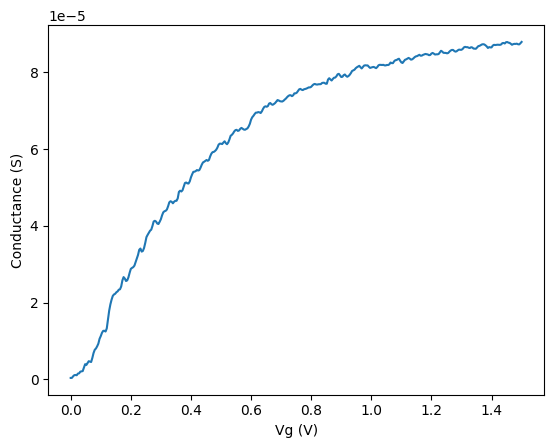

In [2]:
data=np.loadtxt('exampledata2.dat')

Vg=data[0]
G=data[1] #*7.748091729e-5 If data recorded in units of 2e2/h, multiply by conductance quantum

holes=False #Set to True if your device is p-type, False if n-type. Important!

if Vg[-1]<Vg[0]:  #Everything gets way easier in the backend if we insist on Vg ascending
    Vg=Vg[::-1]
    G=G[::-1]
    
plt.plot(Vg,G)
plt.xlabel('Vg (V)')
plt.ylabel('Conductance (S)')
plt.show()

## Take the derivative, perform a fit to find the inflection point

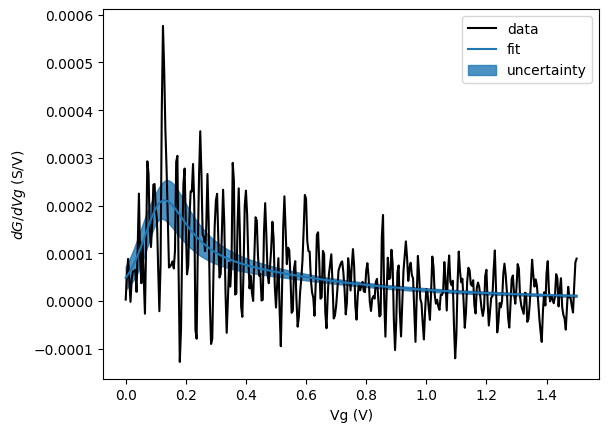

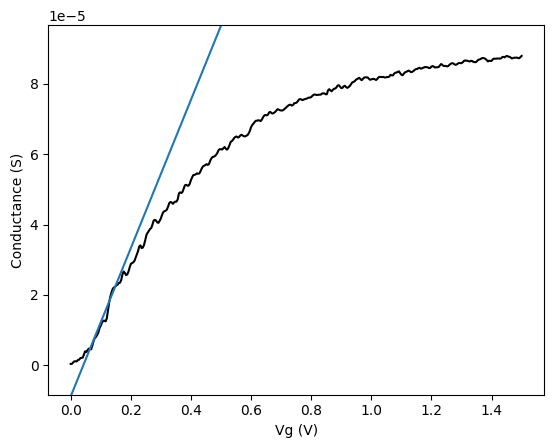

In [3]:
# When taking a numerical derivative, it's often necessary to smooth the data to avoid noise/quantam interference dominating
# To make it easy to understand, we can normalise the smoothing amount to the gate voltage range,
# i.e. smoothing should be a number between 0 and 1

smoothing = 0

if smoothing!=0:
    Gsmooth=savgol_filter(G, int(G.shape[0]*smoothing), 5, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
    dGdVg = np.gradient(Gsmooth, Vg)
else:
    Gsmooth=0 #Necessary since the function still expects something for Gsmooth
    dGdVg = np.gradient(G, Vg)

# If you need to restrict the data to a particular Vg range, specify it here. Otherwise write Vmin='Min', Vmax='Max'
Vmin='Min' #-4  #'Min'
Vmax='Max' #4  #'Max'

plt.plot(Vg,dGdVg,'k',label='data')

#We now can send all the information to the function that performs the fit, and get a bunch of information back
(V0,Vth,Vg_infl,V_Rs,inflectionline,deriv_fit,result_deriv_fit,
fit_uncertainties,V0_uncertainty,Vth_uncertainty,d_Vg_infl)=ma.perform_deriv_fit(Vg,G,dGdVg,
                                                                                   Gsmooth,smoothing,
                                                                                   Vmin=Vmin,Vmax=Vmax,
                                                                                   holes=holes)

# Plot both the fit and the line tangential to the inflection point to make sure it looks sensible.
# It's really important to check here that the tangent line looks sensible. Any error here can propagate.
# If it looks bad, perhaps you need to change the amount of smoothing, or the Vg range.

# If the fit is really bad and you think your eyes can do a better job, uncomment the below, and comment out the perform_deriv_fit function.
# Vg_infl=1.3
# infl_slope=0.00014     #i.e. the y value on the dG/dVg vs Vg plot at the peak
# V0,Vth,V_Rs,inflectionline=ma.manual_inflection(Vg,G,Gsmooth,smoothing,Vg_infl,infl_slope)

plt.plot(Vg,deriv_fit,'tab:blue',label='fit')          #Comment this line if you define the inflection point manually
plt.fill_between(Vg,deriv_fit-fit_uncertainties,deriv_fit+fit_uncertainties,color='tab:blue',alpha=0.8,label='uncertainty')
plt.xlabel('Vg (V)')
plt.ylabel('$dG/dVg$ (S/V)')
plt.legend()
plt.show()

plt.plot(Vg,G,color='k')
plt.plot(Vg,inflectionline,color='tab:blue')
plt.xlabel('Vg (V)')
plt.ylabel('Conductance (S)')
plt.ylim([G.min()-(G.max()-G.min())/10,G.max()+(G.max()-G.min())/10])
plt.show()

## Find the series resistance

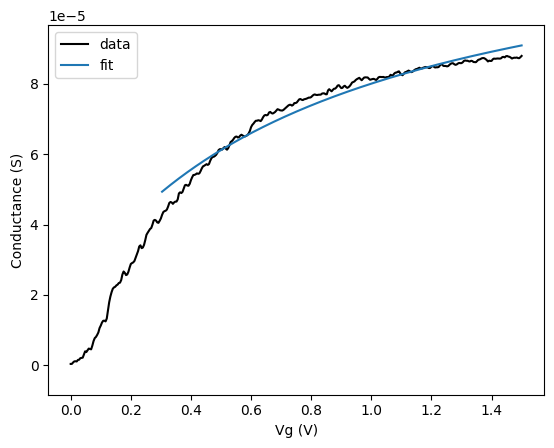

In [4]:
#To calculate the effective mobility and density, we need to know the series resistance Rs. 
#To find Rs, we use the Drude model only at large Vg, where Rs is large compared to the device resistance
#We now need to know a few more things...
L = 3.6e-6   #Device/gate length in meters
d_L = 0.1e-6 #Uncertainty in device length in meters
C = 5.3e-15  #Gate capacitance in farad
d_C = 0.1e-15 #Uncertainty in gate capacitance in farad
initial_Rs = 10000  #A rough guess for Rs in Ohm, to give the fit somewhere to start. 1/G_max is a good guess...
initial_mu = 0.4    #A rough guess for mu in m^2/(Vs). Note!! Not cm^2

Rs,Rs_fit,V_Rs_ind,result_drudeRs=ma.perform_Rs_fit(Vg,G,V0,V_Rs,initial_Rs,initial_mu,L,C,holes)
Rs_uncertainty=result_drudeRs.params['Rs'].stderr

#Check that the fit looks good. If not, try to change the initial guesses
plt.plot(Vg,G,color='k',label='data')
if holes:
    plt.plot(Vg[:V_Rs_ind],Rs_fit,color='tab:blue',label='fit')
else:
    plt.plot(Vg[V_Rs_ind:],Rs_fit,color='tab:blue',label='fit')
plt.xlabel('Vg (V)')
plt.ylabel('Conductance (S)')
plt.ylim([G.min()-(G.max()-G.min())/10,G.max()+(G.max()-G.min())/10])
plt.legend()
plt.show()

#If you know Rs for sure, e.g. if you have an independent, better method of finding it for this device,
#or if you know the Rs is zero, or close to zero, you might want to just write Rs= XX and Rs_uncertainty=YY and skip this cell.

## Calculate effective mobility and density

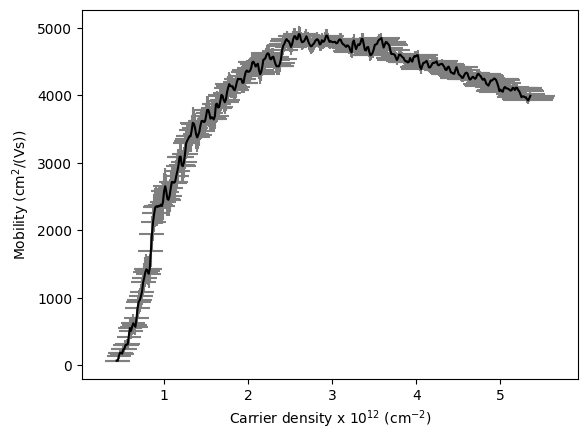

In [5]:
#To calculate the density, we need to know the capacitance per area.
#If you have a rectangular device, and know the channel/gate width, it's easy
#If you have e.g. a backgated nanowire, you need to know the capacitance per area from a simulation/calculation.
#Uncomment the below as necessary

# CperA=5.2e-3
# d_CperA=0.3e-3

width=280e-9
d_width=10e-9
CperA = C/(L*width)
d_CperA = np.sqrt((d_C/C)**2+(d_L/L)**2+(d_width/width)**2)*CperA  # Uncertainty in CperA automatically calculated from previous uncorrelated uncertainties

plotstart=(np.abs(Vg - (2*Vth-Vg_infl))).argmin() # Plot only for density > density(V0)
if holes:
    density=CperA*(V0-Vg)/1.602176634e-19
    mu_eff=L**2/(C*(V0-Vg)*((1/G)-Rs))
    d_mu_eff,d_density = ma.compute_mu_uncertainties(Vg,G,L,C,CperA,V0,Rs,d_L,d_C,d_CperA,V0_uncertainty,Rs_uncertainty,holes)
    plt.errorbar(density[:plotstart]*1e-12/1e4,mu_eff[:plotstart]*1e4,xerr=d_density[:plotstart]*1e-12/1e4,
    yerr=d_mu_eff[:plotstart]*1e4,color='k',ecolor='gray',label='mu_eff')
else:
    density=CperA*(Vg-V0)/1.602176634e-19
    mu_eff=L**2/(C*(Vg-V0)*((1/G)-Rs))
    d_mu_eff,d_density = ma.compute_mu_uncertainties(Vg,G,L,C,CperA,V0,Rs,d_L,d_C,d_CperA,V0_uncertainty,Rs_uncertainty,holes)
    plt.errorbar(density[plotstart:]*1e-12/1e4,mu_eff[plotstart:]*1e4,xerr=d_density[plotstart:]*1e-12/1e4,
    yerr=d_mu_eff[plotstart:]*1e4,color='k',ecolor='gray',label='mu_eff')
plt.xlabel('Carrier density x 10$^{12}$ (cm$^{-2}$)')
plt.ylabel('Mobility (cm$^2$/(Vs))')
plt.show()

## Perform a drude fit

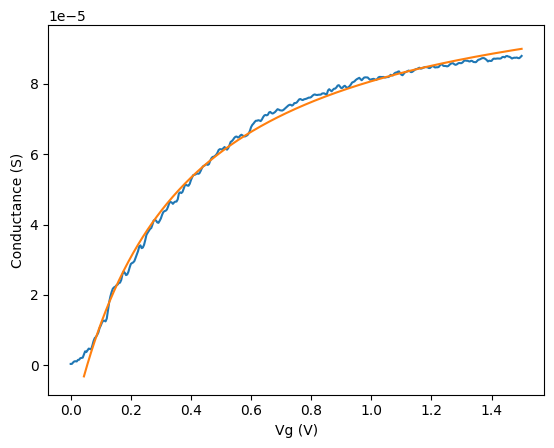

In [ ]:
# If you really want to do it the old way, you can.

mu_FET,drude_fit,Rs_drude,Vth_ind,result_drude=ma.perform_drude_fit(Vg,G,Vth,initial_Rs,initial_mu,L,C,holes)

plt.plot(Vg,G,color='k',label='data')
if holes:
    plt.plot(Vg[:Vth_ind],drude_fit,label='drude fit')
else:
    plt.plot(Vg[Vth_ind:],drude_fit,label='drude fit')
plt.xlabel('Vg (V)')
plt.ylabel('Conductance (S)')
plt.ylim([G.min()-(G.max()-G.min())/10,G.max()+(G.max()-G.min())/10])
plt.legend()
plt.show()

result_drude 
#Note; the lmfit results were returned for each previous fit as well
#If the fitting isn't going well, it can be very helpful to print the fit results.
#It may help guide towards better initial guesses.

# All in one go

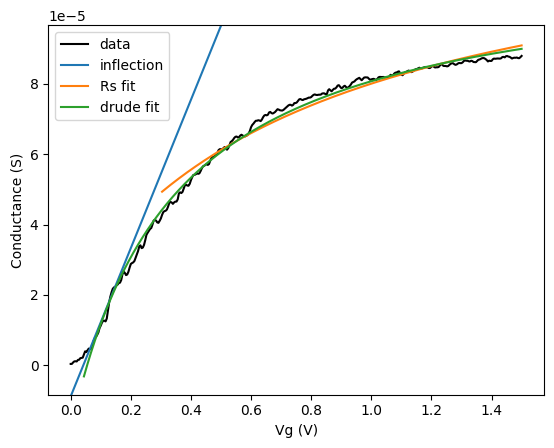

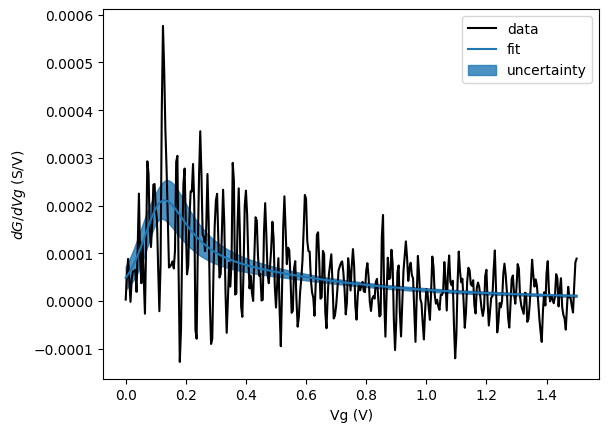

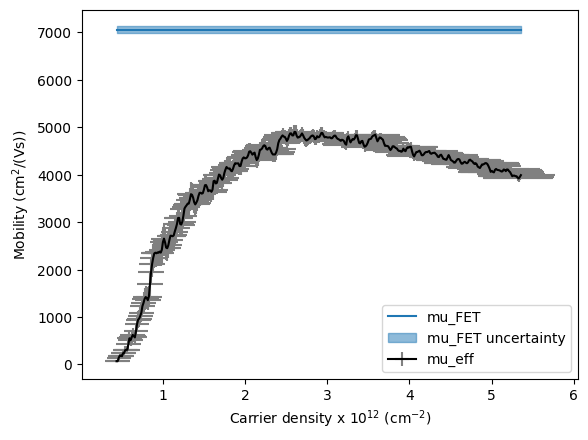

In [7]:
#If you know all your parameters in advance, and the fitting is working well, you can batch process results.
data=np.loadtxt('exampledata2.dat')
Vg=data[0]
G=data[1]#*7.748091729e-5
holes=False
smoothing=0
Vmin='Min' #-4
Vmax='Max' #4
L = 3.6e-6
d_L = 0.1e-6
C = 5.3e-15
d_C = 0.31e-15
CperA=C/(L*280e-9)
d_CperA=np.sqrt((d_C/C)**2+(d_L/L)**2+(10e-9/280e-9)**2)*CperA
initial_Rs = 10000
initial_mu = 0.4

datadict,paramdict=ma.perform_entire_prodecure(Vg,G,smoothing,Vmin,Vmax,L,d_L,C,d_C,CperA,d_CperA,
                                               initial_Rs,initial_mu,holes=holes,
                                               plotting=True,findRs=True,d_Rs=None)

# The function returns two dictionaries; one with all the data, and one with all the parameters, just like in the GUI.
# Plotting can be turned off, but I wouldn't recommend it. It's always important to visually confirm the fits are behaving properly.
# If you know Rs, put findRs=False and the initial_Rs value will be used as the fixed Rs. 
# You should then provide also an uncertainty for Rs, d_Rs

# Code for support functions

In [4]:
# Below are the functions used throughout, should you need to edit them
# The most likely scenario is that you need to change the fitting model, 
# or the initial guesses, especially for the derivative fit.
# After editing as required, instead of calling on ma.function, just call on the function. 
# e.g. ma.perform_deriv_fit -> perform_deriv_fit
# You will need to import some modules from lmfit
from lmfit import Model, Parameters, minimize

In [ ]:
def perform_deriv_fit(Vg,G,dGdVg,Gsmooth,smoothing,Vmin,Vmax,holes=False):
    
    if holes:           #Flipping the data as if it was electrons means we can stick with good initial guesses no matter what
        dGdVg=-dGdVg[::-1]

    minoptions=['Min','','min']
    if Vmin not in minoptions:
        Vmin=float(Vmin)
        min_ind=(np.abs(Vg - Vmin)).argmin()
    else:
        min_ind=1 #To avoid ends
        Vmin=Vg[min_ind]
    maxoptions=['Max','','max']
    if Vmax not in maxoptions:
        Vmax=float(Vmax)
        max_ind=(np.abs(Vg - Vmax)).argmin()
    else:
        max_ind=int(Vg.shape[0]-2)
        Vmax=Vg[max_ind]

    def asym_lorentzian(A, x0, a, u0, x):
        u = 2 * u0 / (1 + np.exp(a * (x - x0)))
        return 2 * A / (np.pi * u) * (1 + 4 * ((x - x0) / u)**2)**-1

    # Define the lmfit model for the asymmetric Lorentzian
    def model(params, x):
        A = params['A'].value
        x0 = params['x0'].value
        a = params['a'].value
        u0 = params['u0'].value
        return asym_lorentzian(A, x0, a, u0, x)

    # Create a lmfit Parameters object with initial guesses for the asymmetric lorentzian
    params = Parameters()
    params.add('A', value=np.max(dGdVg),min=0)  # Use max of data as the initial guess for A
    params.add('x0', value=(Vmax+Vmin)/2)  # Use the middle of the data as the initial guess for x0
    params.add('a', -1,max=0)
    params.add('u0', value=(Vmax-Vmin)/10,min=0)
    
    # Define the residual function to fit the gradient
    def residual(params, x, data):
        model_values = model(params, x)
        return data - model_values

    # Perform the fit using lmfit
    result = minimize(residual, params, args=(Vg[min_ind:max_ind], dGdVg[min_ind:max_ind]))

    d_Vg_infl=result.params['x0'].stderr #This is the uncertainty in the voltage at the inflection point; we'll use it later
    # if d_Vg_infl<np.abs(smoothing*(Vg[-1]-Vg[0])): #If the uncertainty is is smaller than the uncertainty generated by smoothing, this is the larger uncertainty
    #     d_Vg_infl=np.abs(smoothing*(Vg[-1]-Vg[0]))

    # Generate two versions of the best-fit curve; one for plotting, one for extracting values more precisely
    Vgfine=np.linspace(Vg[min_ind],Vg[max_ind],10001) #Makes the method more robust to sparse datasets.
    deriv_fit = model(result.params, Vg)
    deriv_fitfine = model(result.params, Vgfine)
    
    fit_uncertainties=compute_asym_uncertainties(result, Vg) #Compute the uncertainty in the fit to dGdVg as a function of Vg
    fit_uncertainties_fine=compute_asym_uncertainties(result, Vgfine)

    infl_slope=deriv_fitfine.max()    #Slope in G(Vg) at the inflection point is simply the maximum of the derivative
    infl_ind=deriv_fitfine.argmax()   #Array index where inflection point occurs
    infl_slope_uncertainty=fit_uncertainties_fine[infl_ind]     #Uncertainty in the slope
    
    if holes: #Since we flipped the derivative data earlier, we need to reverse everything.
        infl_slope=-infl_slope
        deriv_fit=-deriv_fit[::-1]
        fit_uncertainties=-fit_uncertainties[::-1]
        Vg_infl=Vgfine[-infl_ind]             #Value of Vg at the inflection point
        Vg_infl_min=Vgfine[-infl_ind] + d_Vg_infl
        Vg_infl_max=Vgfine[-infl_ind] - d_Vg_infl
    else:
        Vg_infl=Vgfine[infl_ind]             #Value of Vg at the inflection point
        Vg_infl_min=Vgfine[infl_ind] - d_Vg_infl
        Vg_infl_max=Vgfine[infl_ind] + d_Vg_infl

    if smoothing !=0:
        G_infl=np.interp(Vg_infl, Vg, Gsmooth)
        G_infl_max=np.interp(Vg_infl_max, Vg, Gsmooth)
        G_infl_min=np.interp(Vg_infl_min, Vg, Gsmooth)
    else:
        G_infl=np.interp(Vg_infl, Vg, G)#G[infl_ind]  #Value of G at the inflection point
        G_infl_max=np.interp(Vg_infl_max, Vg, G)
        G_infl_min=np.interp(Vg_infl_min, Vg, G)

    Vth=Vg_infl-(G_infl/infl_slope)   #The 'threshold' voltage.
    #Calculate the uncertainty in Vth using the min and max of the dependent variables
    Vth_min=Vg_infl_min-(G_infl_min/(infl_slope-infl_slope_uncertainty))
    Vth_max=Vg_infl_max-(G_infl_max/(infl_slope+infl_slope_uncertainty))
    Vth_uncertainty = np.abs(Vth_max-Vth_min)/2

    V0 = Vth-2*(Vg_infl-Vth)         #Vg for which density extrapolates to zero.
    #V0_uncertainty = np.sqrt(Vth_uncertainty**2 + (2*d_Vg_infl)**2)  # Propogate as if independent, which isn't strictly true.
    V0_uncertainty = Vth_uncertainty + 2*d_Vg_infl   # A better estimate of the uncertainty is probably just to add the two contributing uncertainties in proportion.

    V_Rs = Vg_infl+2*(Vg_infl-Vth)   #Vg above which we will use to calculate series resistance
    
    inflectionline=G_infl+infl_slope*(Vg-Vg_infl)      #Draw a line tangential with the inflection point. Vg-intercept is Vth

    return V0,Vth,Vg_infl,V_Rs,inflectionline,deriv_fit,result,fit_uncertainties,V0_uncertainty,Vth_uncertainty,d_Vg_infl

def compute_asym_uncertainties(result, Vg):
    # To propogate uncertainties, need to have partial derivatives of the model with respect to the parameters.
    # e.g. f_A is the partial derivative of the asymmetric lorentzian with respect to A.
    # The uncertainty in the parameters, e.g. d_A comes from the fit result. The total uncertainty is then
    # d_F = sqrt((d_A*f_A)^2 + (d_x0*f_x0)^2 + (d_a*f_a)^2 + (d_u0*f_u0)^2)

    def f_A(x,A,x0,a,u0):
        return (np.exp(a*(x - x0)) + 1)/(np.pi*u0*(1 + (x - x0)**2*(np.exp(a*(x - x0)) + 1)**2/u0**2))
    def f_x0(x,A,x0,a,u0):
        return -A*a*np.exp(a*(x - x0))/(np.pi*u0*(1 + (x - x0)**2*(np.exp(a*(x - x0)) + 1)**2/u0**2)) + A*(2*a*(x - x0)**2*(np.exp(a*(x - x0)) + 1)*np.exp(a*(x - x0))/u0**2 - (-2*x + 2*x0)*(np.exp(a*(x - x0)) + 1)**2/u0**2)*(np.exp(a*(x - x0)) + 1)/(np.pi*u0*(1 + (x - x0)**2*(np.exp(a*(x - x0)) + 1)**2/u0**2)**2)
    def f_a(x,A,x0,a,u0):
        return A*(x - x0)*np.exp(a*(x - x0))/(np.pi*u0*(1 + (x - x0)**2*(np.exp(a*(x - x0)) + 1)**2/u0**2)) - 2*A*(x - x0)**3*(np.exp(a*(x - x0)) + 1)**2*np.exp(a*(x - x0))/(np.pi*u0**3*(1 + (x - x0)**2*(np.exp(a*(x - x0)) + 1)**2/u0**2)**2)
    def f_u0(x,A,x0,a,u0):
        return -A*(np.exp(a*(x - x0)) + 1)/(np.pi*u0**2*(1 + (x - x0)**2*(np.exp(a*(x - x0)) + 1)**2/u0**2)) + 2*A*(x - x0)**2*(np.exp(a*(x - x0)) + 1)**3/(np.pi*u0**4*(1 + (x - x0)**2*(np.exp(a*(x - x0)) + 1)**2/u0**2)**2)
    
    A=result.params['A'].value
    d_A=result.params['A'].stderr
    x0=result.params['x0'].value
    d_x0=result.params['x0'].stderr
    a=result.params['a'].value
    d_a=result.params['a'].stderr
    u0=result.params['u0'].value
    d_u0=result.params['u0'].stderr

    d_F=np.sqrt((d_A*f_A(Vg,A,x0,a,u0))**2 + (d_x0*f_x0(Vg,A,x0,a,u0))**2 + (d_a*f_a(Vg,A,x0,a,u0))**2 + (d_u0*f_u0(Vg,A,x0,a,u0))**2)

    return d_F

def compute_mu_uncertainties(Vg,G,L,C,CperA,V0,Rs,d_L,d_C,d_CperA,d_V0,d_Rs,holes=False):
    def f_L(Vg,G,L,C,V0,Rs,holes):
        if not holes:
            return 2*L/(C*(Rs + 1/G)*(-V0 + Vg))
        else: 
            return 2*L/(C*(Rs + 1/G)*(V0 - Vg))
    def f_C(Vg,G,L,C,V0,Rs,holes):
        if not holes:
            return -L**2/(C**2*(Rs + 1/G)*(-V0 + Vg))
        else:
            return -L**2/(C**2*(Rs + 1/G)*(V0 - Vg))
    def f_V0(Vg,G,L,C,V0,Rs,holes):
        if not holes:
            return L**2/(C*(Rs + 1/G)*(-V0 + Vg)**2)
        else:
            return L**2/(C*(Rs + 1/G)*(V0 - Vg)**2)
    def f_Rs(Vg,G,L,C,V0,Rs,holes):
        if not holes:
            return -L**2/(C*(Rs + 1/G)**2*(-V0 + Vg))
        else:
            return -L**2/(C*(Rs + 1/G)**2*(V0 - Vg))
    
    d_mu=np.sqrt((f_L(Vg,G,L,C,V0,Rs,holes)*d_L)**2 + (f_C(Vg,G,L,C,V0,Rs,holes)*d_C)**2 + (f_V0(Vg,G,L,C,V0,Rs,holes)*d_V0)**2 + (f_Rs(Vg,G,L,C,V0,Rs,holes)*d_Rs)**2)

    if not holes:
        d_density=np.sqrt(((Vg - V0)*d_CperA/1.602176634e-19)**2 + (CperA*d_V0/1.602176634e-19)**2)
    else:
        d_density=np.sqrt(((V0 - Vg)*d_CperA/1.602176634e-19)**2 + (CperA*d_V0/1.602176634e-19)**2)
    
    return d_mu,d_density

def manual_inflection(Vg,G,Gsmooth,smoothing,Vg_infl,infl_slope):
    if smoothing !=0:
        G_infl=np.interp(Vg_infl, Vg, Gsmooth)#Gsmooth[infl_ind]
    else:
        G_infl=np.interp(Vg_infl, Vg, G)#G[infl_ind]  #Value of G at the inflection point

    G_intercept = G_infl-infl_slope*Vg_infl  #Finding 'threshold' voltage
    Vth=-G_intercept/infl_slope
    
    V_Rs = Vg_infl+2*(Vg_infl-Vth)   #Vg above which we will use to calculate series resistance
    
    inflectionline=infl_slope*Vg+G_intercept      #Draw a line tangential with the inflection point. Vg-intercept is Vth

    V0 = Vth-2*(Vg_infl-Vth)         #Vg for which density extrapolates to zero.

    return V0,Vth,V_Rs,inflectionline

def drude(x, Rs,mu,Vth,L,c,holes=False):    # drude fit 
    if holes:
        return 1/(Rs + L**2/(mu*c*(Vth-x)))
    else:
        return 1/(Rs + L**2/(mu*c*(x-Vth)))
model_drude = Model(drude)

def perform_Rs_fit(Vg,G,V0,V_Rs,initial_Rs,initial_mu,L,c,holes=False):
    params_Rs = Parameters()
    params_Rs.add('Rs',value=initial_Rs)
    params_Rs.add('mu',value=initial_mu)
    params_Rs.add('Vth',value=V0,vary=False) #Do not vary this parameter, since we know it now.
    params_Rs.add('L',value=L,vary=False)
    params_Rs.add('c',value=c,vary=False)
    params_Rs.add('holes',value=holes,vary=False)

    # Perform the Drude fit over limited range, where Rchannel starts to fall below Rs
    V_Rs_ind = (np.abs(Vg - V_Rs)).argmin()
    if holes:
        result_drudeRs = model_drude.fit(G[:V_Rs_ind], params_Rs, x=Vg[:V_Rs_ind])
    else:
        result_drudeRs = model_drude.fit(G[V_Rs_ind:], params_Rs, x=Vg[V_Rs_ind:])
    Rs = result_drudeRs.params['Rs'].value             ## This is THE value of Rs
    mu_Rs = result_drudeRs.params['mu'].value          # Meaningless value

    if holes:
        Rs_fit = drude(Vg[:V_Rs_ind],Rs,mu_Rs,V0,L,c,holes)
    else:
        Rs_fit = drude(Vg[V_Rs_ind:],Rs,mu_Rs,V0,L,c)
    
    return Rs,Rs_fit,V_Rs_ind,result_drudeRs

def perform_drude_fit(Vg,G,Vth,initial_Rs,initial_mu,L,c,holes=False,findRs=True):
    params_drude = Parameters()
    params_drude.add('Rs',value=initial_Rs,vary=findRs) #Allow to vary for the purpose of illustration.
    params_drude.add('mu',value=initial_mu)
    params_drude.add('Vth',value=Vth) #Can/should vary now.
    params_drude.add('L',value=L,vary=False)
    params_drude.add('c',value=c,vary=False)
    params_drude.add('holes',value=holes,vary=False)

    # Perform the Drude fit over 'full' range. Which is still Vg>Vth
    Vth_ind=(np.abs(Vg - Vth)).argmin()
    if holes:
        result_drude = model_drude.fit(G[:Vth_ind], params_drude, x=Vg[:Vth_ind])
    else:
        result_drude = model_drude.fit(G[Vth_ind:], params_drude, x=Vg[Vth_ind:])
    Rs_drude = result_drude.params['Rs'].value
    mu_drude = result_drude.params['mu'].value
    Vth_drude=result_drude.params['Vth'].value
    
    if holes:
        drude_fit = drude(Vg[:Vth_ind],Rs_drude,mu_drude,Vth_drude,L,c,holes)
    else:
        drude_fit = drude(Vg[Vth_ind:],Rs_drude,mu_drude,Vth_drude,L,c)
    
    return mu_drude,drude_fit,Rs_drude,Vth_ind,result_drude

def perform_entire_prodecure(Vg,G,smoothing,Vmin,Vmax,L,d_L,C,d_C,CperA,d_CperA,initial_Rs,initial_mu,
                             holes=False,plotting=True,findRs=True,d_Rs=None):

    datadict={}
    paramdict={}
    
    if Vg[-1]<Vg[0]:
        Vg=Vg[::-1]
        G=G[::-1]
    datadict['Vg (V)']=Vg
    datadict['G (S)']=G

    if smoothing!=0:
        Gsmooth=savgol_filter(G, int(G.shape[0]*smoothing), 5, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)
        dGdVg = np.gradient(Gsmooth, Vg)
    else:
        Gsmooth=0 #Necessary later because I'm not a good developer, sorry
        dGdVg = np.gradient(G, Vg)
    datadict['dGdVg (S/V)']=dGdVg

    (V0,Vth,Vg_infl,V_Rs,inflectionline,deriv_fit,result_deriv_fit,
    fit_uncertainties,V0_uncertainty,Vth_uncertainty,d_Vg_infl)=perform_deriv_fit(Vg,G,
                                                                                    dGdVg,Gsmooth,smoothing,
                                                                                    Vmin=Vmin,Vmax=Vmax,
                                                                                    holes=holes)
    datadict['dGdVg fit (S/V)']=deriv_fit
    datadict['dGdVg fit uncertainties (S/V)']=fit_uncertainties
    datadict['Inflection fit (S)']=inflectionline
    paramdict['V0 (V)']=V0
    paramdict['V0 uncertainty (V)']=V0_uncertainty
    paramdict['Vth (V)']=Vth
    paramdict['Vth uncertainty (V)']=Vth_uncertainty
    paramdict['Vg_infl (V)']=Vg_infl
    paramdict['Vg_infl uncertainty (V)']=d_Vg_infl
    paramdict['V_Rs (V)']=V_Rs
        
    if findRs==False:
        Rs=initial_Rs
        d_Rs=d_Rs
    elif findRs==True:
        Rs,Rs_fit,V_Rs_ind,result_drudeRs=perform_Rs_fit(Vg,G,V0,V_Rs,initial_Rs,initial_mu,L,C,holes)
        if holes:
            datadict['Vg for Rs fit (V)']=Vg[:V_Rs_ind]
        else:
            datadict['Vg for Rs fit (V)']=Vg[V_Rs_ind:]
        datadict['Rs fit (S)']=Rs_fit
        d_Rs=result_drudeRs.params['Rs'].stderr
    else:
        raise ValueError('findRs must be True or False')
    paramdict['Rs (Ohm)']=Rs
    paramdict['Rs uncertainty (Ohm)']=d_Rs
    
    if holes:
        density=CperA*(V0-Vg)/1.602176634e-19
        mu_eff=L**2/(C*(V0-Vg)*((1/G)-Rs))
    else:
        density=CperA*(Vg-V0)/1.602176634e-19
        mu_eff=L**2/(C*(Vg-V0)*((1/G)-Rs))
    d_mu_eff,d_density = compute_mu_uncertainties(Vg,G,L,C,CperA,V0,Rs,d_L,d_C,d_CperA,V0_uncertainty,d_Rs,holes)
    datadict['density (1/m2)']=density
    datadict['mu_eff (m2/Vs)']=mu_eff
    datadict['density uncertainties (1/m2)']=d_density
    datadict['mu_eff uncertainties (m2/Vs)']=d_mu_eff

    mu_drude,drude_fit,Rs_drude,Vth_ind,result_drude=perform_drude_fit(Vg,G,Vth,
                                                                       initial_Rs,initial_mu,
                                                                       L,C,holes,findRs)
    paramdict['mu_FET (m2/Vs)']=mu_drude
    paramdict['mu_FET uncertainty (m2/vs)']=result_drude.params['mu'].stderr
    if holes:
        datadict['Vg for mu_FET fit (V)']=Vg[:Vth_ind]
    else:
        datadict['Vg for mu_FET fit (V)']=Vg[Vth_ind:]
    datadict['mu_FET fit (S)']=drude_fit
    
    if plotting==True:
        plt.plot(Vg,G,label='data',color='k')
        plt.plot(Vg,inflectionline,label='inflection')
        if holes:
            if findRs==True:
                plt.plot(Vg[:V_Rs_ind],Rs_fit,label='Rs fit')
            plt.plot(Vg[:Vth_ind],drude_fit,label='drude fit')
        else:
            if findRs==True:
                plt.plot(Vg[V_Rs_ind:],Rs_fit,label='Rs fit')
            plt.plot(Vg[Vth_ind:],drude_fit,label='drude fit')
        plt.xlabel('Vg (V)')
        plt.ylabel('Conductance (S)')
        plt.ylim([G.min()-(G.max()-G.min())/10,G.max()+(G.max()-G.min())/10])
        plt.legend()
        plt.show()

        plt.plot(Vg,dGdVg,color='k',label='data')
        plt.plot(Vg,deriv_fit,'tab:blue',label='fit')
        plt.fill_between(Vg,deriv_fit-fit_uncertainties,deriv_fit+fit_uncertainties,color='tab:blue',alpha=0.8,label='uncertainty')
        plt.xlabel('Vg (V)')
        plt.ylabel('$dG/dVg$ (S/V)')
        plt.legend()
        plt.show()
        
        mu_drude_array=np.full(Vg.shape[0],mu_drude)
        plotstart=(np.abs(Vg - (2*Vth-Vg_infl))).argmin()
        if holes:
            plt.errorbar(density[:plotstart]*1e-12/1e4,mu_eff[:plotstart]*1e4,xerr=d_density[:plotstart]*1e-12/1e4,
                        yerr=d_mu_eff[:plotstart]*1e4,color='k',ecolor='gray',label='mu_eff')
            plt.plot(density[:plotstart]*1e-12/1e4,mu_drude_array[:plotstart]*1e4,label='mu_FET')
            plt.fill_between(density[:plotstart]*1e-12/1e4,(mu_drude_array[:plotstart]-result_drude.params['mu'].stderr)*1e4,
                            (mu_drude_array[:plotstart]+result_drude.params['mu'].stderr)*1e4,
                            alpha=0.5,color='tab:blue',label='mu_FET uncertainty')
        else:
            plt.errorbar(density[plotstart:]*1e-12/1e4,mu_eff[plotstart:]*1e4,xerr=d_density[plotstart:]*1e-12/1e4,
                        yerr=d_mu_eff[plotstart:]*1e4,color='k',ecolor='gray',label='mu_eff')
            plt.plot(density[plotstart:]*1e-12/1e4,mu_drude_array[plotstart:]*1e4,label='mu_FET')
            plt.fill_between(density[plotstart:]*1e-12/1e4,(mu_drude_array[plotstart:]-result_drude.params['mu'].stderr)*1e4,
                            (mu_drude_array[plotstart:]+result_drude.params['mu'].stderr)*1e4,
                            alpha=0.5,color='tab:blue',label='mu_FET uncertainty')
        plt.xlabel('Carrier density x 10$^{12}$ (cm$^{-2}$)')
        plt.ylabel('Mobility (cm$^2$/(Vs))')
        plt.legend()
        plt.show()
    return datadict,paramdict